<img src="files/image.jpg">

# *Including wildfires in a landscape evolution model*
### --- Nishani Moragoda, Kevin Pierce, Laurent Roberge ---

## Introduction

---small blurb about wildfires---
--- Landscape evolution models
--- Fluvial sediment flux
--- Fires

... In this lab we will explore the sediment flux response to stochastic wildfires that increase soil erodibility on the landscape.

## Model information

### Fastscape Eroder

The **Fastscape Eroder** is an efficient fluvial incision model that uses the Braun-Willett approach to solving the stream power equation:

\begin{equation}
\frac{d z}{d t} = -KA^{m}S^{n} + U 
\end{equation}

Where $dz/dt$ is the rate of change of elevation, $K$ is the erodibility coefficient, $A$ is the upstream drainage area, $S$ is channel slope, and $m$ and $n$ are empirical exponents. $U$ is uplift.

This stream power equation is a typical equation used to generate fluvial networks in landscape evolution models. Solving this equation for every point in the landscape generates a steadily eroding bedrock surface. Although this equation is efficient to compute, it does not allow for deposition of sediment, which means that all sediment eroded from the landscape is immediately transported through the watershed outlet.

More details about the **Fastscape Eroder** component in Landlab can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/stream_power.html 

And Braun & Willett’s 2013 paper is here: 

Braun, J., Willett, S. (2013). A very efficient O(n), implicit and parallel method to solve the stream power equation governing fluvial incision and landscape evolution. Geomorphology 180-181(C), 170-179. https://dx.doi.org/10.1016/j.geomorph.2012.10.008 

### SPACE (Stream Power with Alluvium Conservation and Entrainment): 

The **SPACE** component is another model that simulates fluvial processes. Although it is also built on the stream power equation, in contrast to the **Fastscape Eroder** it not only tracks erosion of bedrock, but also entrainment and deposition of sediment on top of the bedrock. The downside is that it takes much longer to solve the more complicated algorithm. Because of this, we will first run the **Fastscape Eroder** to imprint a fluvial network into the grid and then we will switch over to the **SPACE** model to track sediment fluxes as fires affect the landscape. 

More details about the **SPACE** component in Landlab can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/space.html 

And the Shobe et al. (2017) paper is here: 

Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 

### Other components 

We also need the **FlowAccumulator** and **DepressionFinderAndRouter** components. These calculate the routing of flow across the grid and deal depressions/lakes in the landscape. More info can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html 

https://landlab.readthedocs.io/en/master/reference/components/flow_routing.html 

Finally, we have added two modules that are not Landlab components: 

The **Burner** generates stochastic wildfires that burn parts of the landscape and the **Erodibility Stepper** changes the soil erodibility a fire has occurred. These will be described in more detail when they show up in the notebook. 

### Import statements

First, we import the necessary libraries and components. 

In [83]:
import os
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt 
from firemodel import *
from create_network import create_network_from_raster
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from landlab import (RasterModelGrid, imshow_grid)
from landlab.plot import graph
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10] # make figures larger for presentation purposes

### Set some parameters

Here, we set the parameters we'll need for the rest of the lab.

There will be an opportunity to change the burn frequency and explore its effects later.

In [84]:
# Saving outputs
save=True             # save outputs to a directory or not? 
save_dir = './simul/' # directory in which to save outputs

# Grid parameters
dx = 100              # distance between each node (m) 
np.random.seed(5000)  # reproducible random seed to add initial topographic roughness
grid_dim = (50,50)    # number of nodes along each axis (x,y)

# Timesteps, runtime, and uplift rate for Fastscape imprint time window
dt_fs = 1000                # timestep in years
runtime_fs = 2000000        # length of the simulation in years
ndt_fs = runtime_fs//dt_fs  # number of timesteps
U_fs = 0.002                # Uplift rate

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
dt_sp = 1                   # timestep in years
runtime_sp = 1000           # length of the simulation in years
ndt_sp = runtime_sp//dt_sp  # number of timesteps
U_sp = 0.002                # Uplift rate

# Fastscape Eroder parameters
K_sp=0.00001          # erodibility coefficient
m_sp=0.5              # Drainage area exponent
n_sp=1                # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = dt_sp*10     # time it takes the erodibility perturbution to decay

# Burner
R_fire_mean = grid_dim[0]/10*dx    # Mean fire radius
fire_freq = 1/(7*dt_sp)            # Fire frequency
K_sed_boost = 20*K_sed0            # The increase in soil erodibility due to fire

### Instantiate the model grid
Here , we instantiate a 50x50 node model grid (5000x5000 m). The bottom left corner is the watershed outlet, so we set it to an open boundary condition to allow flux out. All other boundary nodes are closed. The initial topography is tilted downwards from the upper right towards the outlet and has random roughness to make it look more natural.

/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


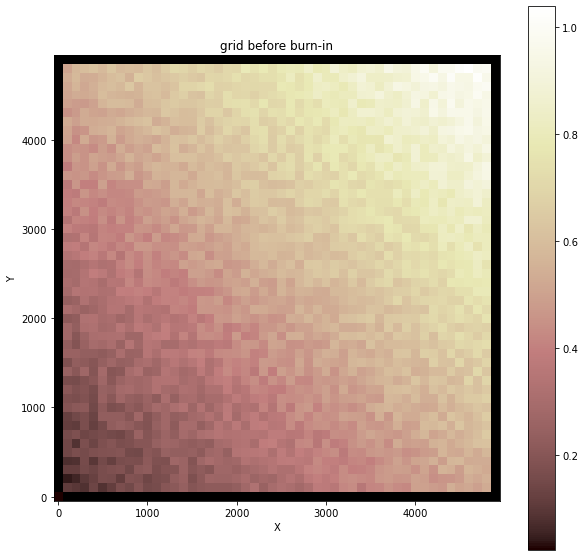

In [85]:
# Instantiate the raster model grid
mg = RasterModelGrid(grid_dim, xy_spacing=dx)
_ = mg.add_zeros('topographic__elevation', at='node')

# Add tilt and seeded random noise to the topography
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y)) / 10.)

# Set the boundary conditions
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)

# Plot the initial topographic conditions
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

### Instantiate the model components for imprinting the initial landscape

Here we instantiate the **Fastscape Eroder**, **Flow Router**, and **Depression Finder**. 

In [86]:
#Instantiate the fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=K_sp,
    m_sp=m_sp,
    n_sp=n_sp)

### Imprint an initial drainage network
We use the **Fastscape eroder** to "burn in" (no pun intended...) an initial drainage network since the algorithm is much faster than **SPACE**. The algorithm calculates quickly across the grid and is also stable at long timesteps. We are able to use 1000-year timesteps here, compared to a maximum of about 10 years for **SPACE**.

We iterate the **Fastscape eroder** through a time loop to evolve the landscape to a steady state before adding soil to set up the conditions for the **SPACE** model.

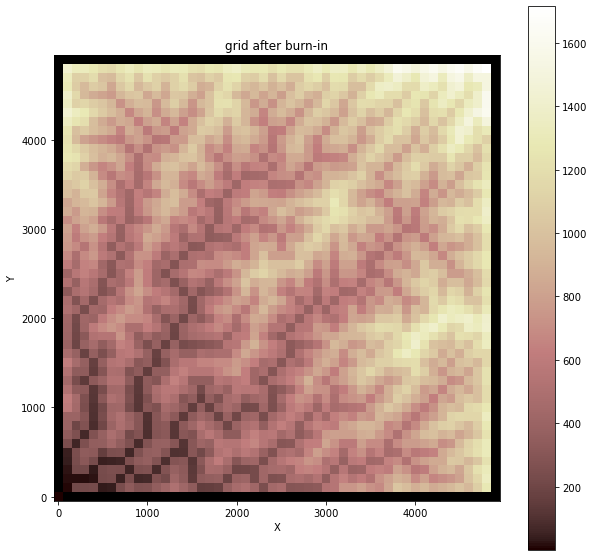

In [87]:
# Create empty array to fill with sediment flux and time values 
sedflux = np.zeros(ndt_fs)
t_sedflux = np.zeros(ndt_fs)

# Time loop running the fastscape eroder
for it in range(ndt_fs):
    elev_1 = mg.at_node['topographic__elevation'][mg.core_nodes]
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=dt_fs)
    elev_2 = mg.at_node['topographic__elevation'][mg.core_nodes]
    mg.at_node['topographic__elevation'][mg.core_nodes] += U_fs*dt_fs # Uplift
    sedflux[it] = sum(elev_1-elev_2)*(dx*dx)/dt_fs
    t_sedflux[it] = it*dt_fs
    
# Add soil to the drainage network (for SPACE)
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']

# Plot the burned in topographic conditions
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()

### Plot sediment flux at the outlet
At steady state, the rate of erosion throughout the landscape matches the rate of uplift, so the sediment flux at the outlet of the watershed is stable through time. Note how sediment flux increases early on when the landscape is adjusting and then since becomes steady after about 1.5 million years. 

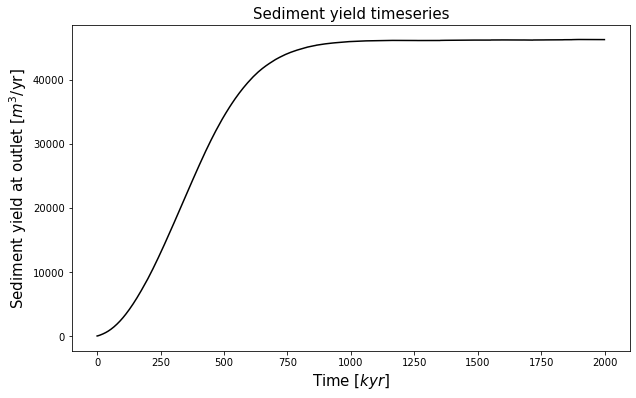

In [88]:
# Plot sediment flux timeseries
plt.plot(t_sedflux/1000,sedflux,color='black')
plt.xlabel('Time [$kyr$]',fontsize=15)
plt.ylabel('Sediment yield at outlet [$m^3$/yr]',fontsize=15)
plt.title('Sediment yield timeseries', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')

plt.show()

### Instantiate the components for exploring the effects of fire
Here, we instantiate **SPACE**, **Erodibility Stepper**, and **Burner**. We also add a layer of soil to the grid. Remember that the **Fastscape Eroder** acts only on bedrock, but **SPACE** acts on sediment as well. The **Burner** will generate a fire, then the **Erodibility Stepper** will increase the erodibility of the soil in the burned area and slowly return the erodibility back to “normal”.  

In [89]:
# Instantiate the SPACE component
K_sed = np.ones(mg.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp = n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br)

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)

# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt_sp,dx=dx)

### Run the landscape evolution model
Here, we iterate the three newly instantiated models through a time loop. This time around, since the erodibility is changing through time due to fires, what do you think the sediment flux timeseries will look like? 

In [90]:
start_time = time.time()

sedflux = np.empty(shape=ndt_sp)
t_sedflux = np.empty(shape=ndt_sp)

for it in range(ndt_sp):
    fr.run_one_step()           # accumulate the flow
    df.map_depressions()        # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt_sp)   # step the transport model
    es.stepper(ha,dt=dt_sp)     # decay the erodibility back toward baseline from the former timestep
    burner.fire(ha,mg,it*dt_sp)          # light any fires (increase erodibility)
    mg.at_node['bedrock__elevation'][mg.core_nodes] += U_sp*dt_sp # incorporate uplift
    sedflux[it] = mg.at_node['sediment__flux'][grid_dim[0]+1] # sediment flux at the outlet node (1,1).
    t_sedflux[it] = it*dt_sp # time at which the sediment flux was recorded
    if it*dt_sp % 10 == 0: # if a decade has gone by, then print 
        print("--", it*dt_sp, "years -- %s seconds --" % round((time.time() - start_time), 1))
#    if (it*dt_sp % 10 == 0) & save: # save every 100 years
#        filename = save_dir + 'simul_%05d.nc'%it
#        filename_npy = save_dir + 'simul_%05d'%it
#        #mg.(filename, names='topographic__elevation')
#        write_netcdf(filename, mg, format="NETCDF3_64BIT", names=["topographic__elevation","sediment__flux"])
#        np.save(filename_npy, K_sed)

fire at (3500.0,1900.0) with 45 nodes inflamed
-- 0 years -- 0.3 seconds --
fire at (4300.0,4500.0) with 57 nodes inflamed
-- 10 years -- 3.1 seconds --
-- 20 years -- 5.9 seconds --
fire at (400.0,4400.0) with 9 nodes inflamed
-- 30 years -- 8.7 seconds --
-- 40 years -- 11.5 seconds --
fire at (3600.0,1300.0) with 1 nodes inflamed
fire at (500.0,1600.0) with 1 nodes inflamed
fire at (2600.0,4700.0) with 9 nodes inflamed
-- 50 years -- 14.2 seconds --
fire at (4000.0,2200.0) with 101 nodes inflamed
fire at (2100.0,3100.0) with 5 nodes inflamed
-- 60 years -- 17.0 seconds --
fire at (0.0,300.0) with 1 nodes inflamed
fire at (400.0,4500.0) with 21 nodes inflamed
-- 70 years -- 19.8 seconds --
fire at (4700.0,2200.0) with 49 nodes inflamed
fire at (3000.0,4400.0) with 61 nodes inflamed
-- 80 years -- 22.6 seconds --
-- 90 years -- 25.3 seconds --
fire at (2800.0,4900.0) with 212 nodes inflamed
fire at (600.0,2700.0) with 1 nodes inflamed
-- 100 years -- 28.1 seconds --
fire at (4200.0,35

fire at (1300.0,500.0) with 9 nodes inflamed
fire at (1800.0,4200.0) with 234 nodes inflamed
-- 900 years -- 261.0 seconds --
fire at (3900.0,4300.0) with 201 nodes inflamed
fire at (4100.0,1000.0) with 61 nodes inflamed
-- 910 years -- 263.8 seconds --
fire at (3500.0,4700.0) with 954 nodes inflamed
-- 920 years -- 266.7 seconds --
fire at (300.0,2100.0) with 162 nodes inflamed
fire at (3900.0,900.0) with 1 nodes inflamed
-- 930 years -- 269.5 seconds --
fire at (2300.0,2200.0) with 221 nodes inflamed
-- 940 years -- 272.4 seconds --
fire at (3700.0,4000.0) with 21 nodes inflamed
fire at (3300.0,3500.0) with 1 nodes inflamed
-- 950 years -- 275.2 seconds --
fire at (4200.0,4900.0) with 9 nodes inflamed
-- 960 years -- 278.1 seconds --
-- 970 years -- 281.0 seconds --
fire at (4500.0,2900.0) with 129 nodes inflamed
-- 980 years -- 283.9 seconds --
-- 990 years -- 286.8 seconds --
fire at (2500.0,2500.0) with 177 nodes inflamed


Text(0.5, 1.0, 'Fire magnitudes through time')

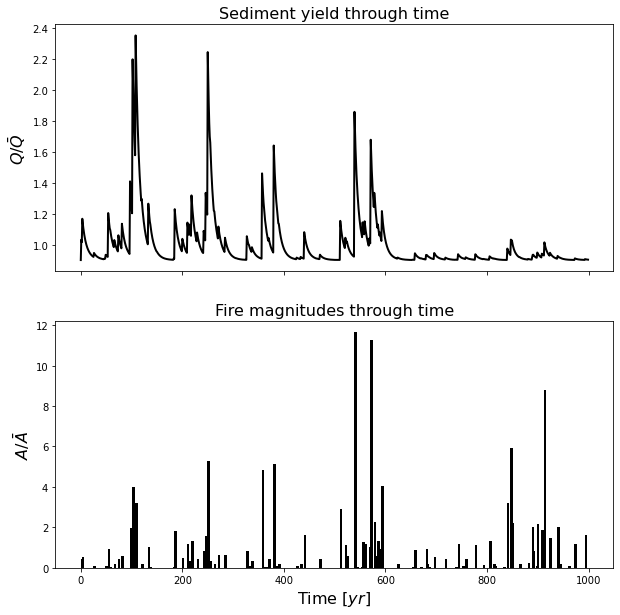

In [91]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(t_sedflux, sedflux/np.mean(sedflux),lw=2,color='black')
ax2.bar(burner.fireTimes,burner.fireSizes/np.mean(burner.fireSizes),width=5,align='edge',lw=2,color='black')

plt.xlabel("Time [$yr$]",fontsize=16)
ax1.set_ylabel(r"$Q/\bar{Q}$",fontsize=16)
ax2.set_ylabel(r"$A/\bar{A}$",fontsize=16)

ax1.set_title('Sediment yield through time',fontsize=16)
ax2.set_title('Fire magnitudes through time',fontsize=16)

### Visualizations

/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


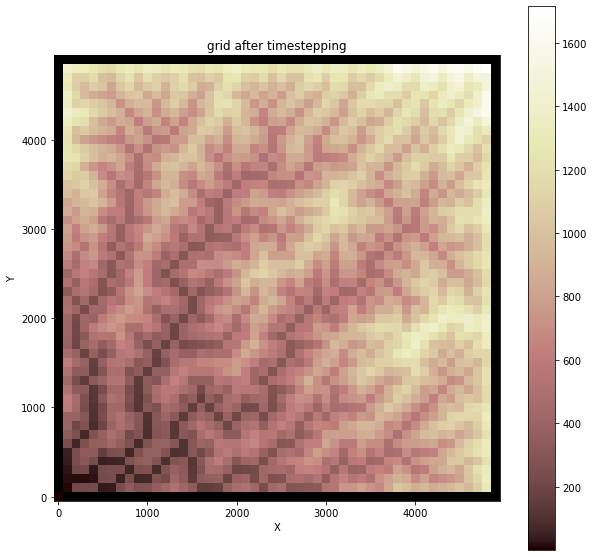

In [79]:
# Topography after evolving the landscape
mg.imshow('node','topographic__elevation')
plt.title('grid after timestepping')
plt.show()

/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad(color=color_for_closed)


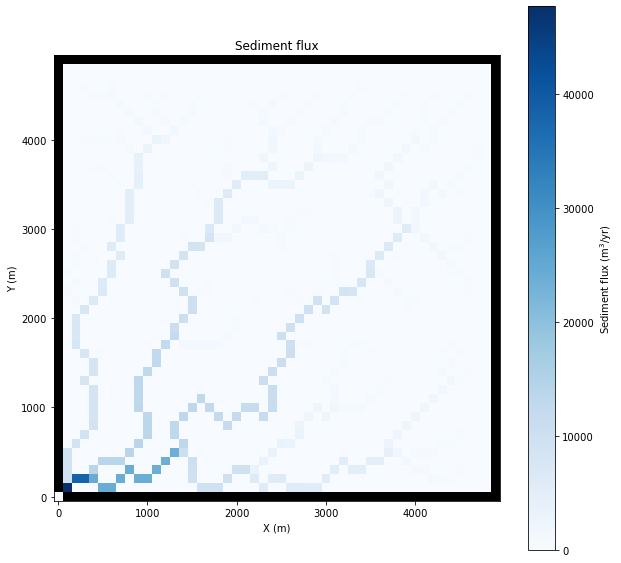

In [80]:
# Map of sediment flux
fig = plt.figure()
plot = plt.subplot()
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='Blues')
plt.show()

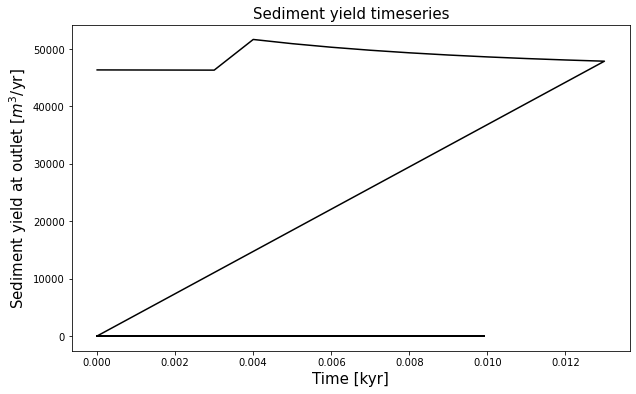

In [81]:
# Plot sediment flux timeseries
plt.plot(t_sedflux/1000,sedflux,color='black')
plt.xlabel('Time [kyr]',fontsize=15)
plt.ylabel('Sediment yield at outlet [$m^3$/yr]',fontsize=15)
plt.title('Sediment yield timeseries', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')

plt.show()

### Output a NetworkModelGrid

In [ ]:
nmg = create_network_from_raster(
    mg,
    method='variable', # method
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

### Define a plotting function

In [ ]:
def plotter(grid,K_sed):
    pinks = plt.get_cmap('pink') # pink colormap
    greys = plt.get_cmap('gist_gray')#plt.get_cmap('gist_gray') # grey colormap
    def cm_black(arr):
        return np.array([0,0,0,0.5]).astype('float')*np.ones_like(arr)[:,np.newaxis]
    #greys = cm_black
    # set up a blank image... 
    im = np.zeros(shape=(grid_dim[0],grid_dim[1],4))

    # get the elevations from the grid
    z = mg.at_node['topographic__elevation']
    zs = (z-z.min())/(z.max()-z.min())
    # determine "burned" locations in the image
    tol = K_sed0*1.5 # tolerance for "burned"
    mask = (K_sed > tol).flatten() # mask of places "burned"

    # get colors for burned locations
    #a = 0.9 #
    a = ((((K_sed-K_sed0)/K_sed_boost)).flatten())[mask][:,np.newaxis]
    a = (a+1)/2
    bvals = greys(zs[mask])*a + pinks(zs[mask])*(1-a)

    # get colors for not burned locations
    vals = pinks(zs[~mask])

    # fill in values within the image..
    smask = np.stack((mask.reshape(grid_dim[0],grid_dim[1]),)*4,-1)
    im[smask] = bvals.flatten()
    im[~smask] = vals.flatten()

    # fill in all edge nodes..
    def edge_mask(x):
        # https://stackoverflow.com/questions/48097068/how-to-get-boundaries-of-an-numpy-array
        mask = np.ones(x.shape, dtype=bool)
        mask[x.ndim * (slice(1, -1),)] = False
        return mask
    edge = edge_mask(im[:,:,0])
    im[edge]=np.array([0,0,0,1])
    
    # plot the image..
    x = np.linspace(0,dx*grid_dim[0],dx)
    y = np.linspace(0,dx*grid_dim[1],dx)
    #x,y = np.meshgrid(x,y)
    plt.imshow(im,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower')
    
    graph.plot_links(nmg,with_id=False)

### Plot showing burned areas

In [ ]:
plotter(mg,K_sed)

In [ ]:
base = './simul/'
save = './imgs/'
files = sorted(os.listdir(base))
ks_files = [f for f in files if f[-3:] == 'npy']
mg_files = [f for f in files if f[-2:] == 'nc']
for f1,f2 in zip(ks_files,mg_files):
    f1p=base+f1
    f2=base+f2
    K_sed = np.load(f1p)
    mg = read_netcdf(f2)
    
    nmg = create_network_from_raster(
                                    mg,
                                    method='variable',
                                    n_widths=dx,
                                    min_channel_thresh=30000,
                                    fields=['drainage_area', 'topographic__elevation']
                                    )
    plotter(mg,K_sed)
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    savename = save + f1[:-3]+'png'
    fig.patch.set_facecolor('white')
    # add in timestamp
    #plt.text(,,'t = {}'.format(round()))
##################################### add in the text with the time
    t = int(f1.split('.')[0].split('_')[1])*dt
    plt.title('{} yr'.format(t),fontsize=20)
    plt.savefig(savename, dpi=100)
    plt.show()
    

In [ ]:
# Map of topographic elevation and the fluvial network
mg.imshow('node','topographic__elevation')
graph.plot_links(nmg,with_id=False)
fig = plt.gcf()
fig.set_size_inches(14, 10)
plt.show()

### Plot a timeseries of sediment flux at the watershed outlet

In [ ]:
# Sediment flux plot
base = './simul/'
save = './imgs/'
files = sorted(os.listdir(base))
mg_files = [f for f in files if f[-2:] == 'nc']
fluxSeries = []
T = []
for f in mg_files:
    mg = read_netcdf(base+f)
    t = int(f.split('.')[0].split('_')[1])*dt
    flux = mg.at_node['sediment__flux']
    fluxSeries.append(flux.max())
    T.append(t)
T = np.array(T)

plt.plot(T/1000,fluxSeries,color='black')
plt.xlabel('time [kyr]',fontsize=15)
plt.ylabel('Yield at outlet [$m^3$/yr]',fontsize=15)
plt.title('Sediment yield variations due to wildfire', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')

plt.savefig('fireFlux.png')

### Make a gif to show the landscape over time

In [ ]:
# Make gif
save = './imgs/'
files = sorted(os.listdir(save))

with imageio.get_writer('movie.mp4', mode='I',fps=12) as writer:
    for f in files:
        #print(f)
        im = imageio.imread(save+f)
        writer.append_data(im)